In [122]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance_matrix
from math import sqrt
import matplotlib.pyplot as plt

#number of cities defined by n
n=7
p=n-1

In [123]:
#generate random weights for the nodes 2,3,...n
def generate_weight_value():
    
    weight=[]
    value=[]

    for i in range(p):
        weight.append(random.randint(10,30))
        value.append(random.randint(20,40))
    return weight,value

def dist(a, b):
    d = [a[0] - b[0], a[1] - b[1]]
    return sqrt(d[0] * d[0] + d[1] * d[1])

#generating random distance between n cities and creating dictionary D which has distance of every city from ith city
def get_distance():
    
    data = [(random.randrange(1, 10), random.randrange(1, 10)) for i in range(n)]
    cords = {}
    for i in range(n):
        cords[str(i+1)] = data[i]
    
    D = {}
    for city1, cords1 in cords.items():
        D[city1] = {}
        for city2, cords2 in cords.items():
            D[city1][city2] = dist(cords1, cords2)
    return D

In [124]:
weight,value=generate_weight_value()
distance=get_distance()
print('weight',weight)
print('value',value)
print('Distance',distance)

weight [21, 27, 10, 10, 21, 27]
value [32, 22, 36, 23, 36, 21]
Distance {'1': {'1': 0.0, '2': 3.1622776601683795, '3': 8.0, '4': 3.1622776601683795, '5': 5.385164807134504, '6': 8.54400374531753, '7': 2.8284271247461903}, '2': {'1': 3.1622776601683795, '2': 0.0, '3': 7.615773105863909, '4': 6.0, '5': 6.4031242374328485, '6': 9.219544457292887, '7': 1.4142135623730951}, '3': {'1': 8.0, '2': 7.615773105863909, '3': 0.0, '4': 7.615773105863909, '5': 3.605551275463989, '6': 3.0, '7': 6.324555320336759}, '4': {'1': 3.1622776601683795, '2': 6.0, '3': 7.615773105863909, '4': 0.0, '5': 4.123105625617661, '6': 7.0, '7': 5.0990195135927845}, '5': {'1': 5.385164807134504, '2': 6.4031242374328485, '3': 3.605551275463989, '4': 4.123105625617661, '5': 0.0, '6': 3.1622776601683795, '7': 5.0}, '6': {'1': 8.54400374531753, '2': 9.219544457292887, '3': 3.0, '4': 7.0, '5': 3.1622776601683795, '6': 0.0, '7': 7.810249675906654}, '7': {'1': 2.8284271247461903, '2': 1.4142135623730951, '3': 6.324555320336759

In [125]:
# generate a population of 10 routes for tour through all cities starting from city: '1'
def generate_pop():
    population=np.empty((10, n), int)
    arr1=np.array([1])
    arr= np.array([i for i in range(2,n+1)])
    for i in range(10):
        random.shuffle(arr)
        population[i]=np.hstack((arr1,arr))
    return population

#generating a population of 10 pickup masks
def generate_pickup():
    pickup=np.empty((10,p), int)
    for i in range(10):
        pickup[i]=np.array([random.randint(0,1) for i in range(p)])
    return pickup
    

In [126]:
init_pop=generate_pop()
init_pickup=generate_pickup()

In [127]:
#calculate the profit for each pickup 
def generate_profit(value,init_pickup):
    profit=np.empty((10,1),int)
    for i in range(10):
        sum=0
        for j in range(p):
            sum+=init_pickup[i][j]*value[j]
        profit[i]=np.array(sum)
    return profit

In [128]:
profit1=generate_profit(value,init_pickup)
profit=profit1.flatten()


In [129]:
#compute total time for a particular tour
def compute_time(pop,pickup,weight,value,distance,vmax,vmin,C):
    coeff=(vmax-vmin)/C
    t=0
    for i in range(n):
        if i<n-1:
            d=distance[str(pop[i])][str(pop[i+1])]
            
        else:
            d=distance[str(pop[i])][str(pop[0])]
        if i==0:
            vel=vmax
            w=0
        else:
            w+=pickup[i-1]*weight[pop[i]-2]
            vel=vmax-coeff*w
            if vel<vmin:
                vel=vmin
        t+=d/vel
    return t
        

In [130]:
time1=time=np.empty((10,1),int)
vmax=1
vmin=0.1
C=20
for i in range(10):
    time1[i]=compute_time(init_pop[i],init_pickup[i],weight,value,distance,vmax,vmin,C)
time=time1.flatten()    

In [131]:
#Fitness function 
def find_fitness(profit,time):
    return profit-time

In [132]:
fitness1=find_fitness(profit1,time1)
fitness=fitness1.flatten()


In [133]:
#Select only best of solution as parents
def find_parents(fitness):
    idx_parent1=np.argsort(fitness)[-1]
    idx_parent2=np.argsort(fitness)[-2]
    return idx_parent1,idx_parent2


In [134]:
#single locus crossover for tour
def crossover(parent1,parent2):
    child1=parent1.copy()
    child2=parent2.copy()
    cross_pnt=random.randint(1,n-1)
    var1=child1[cross_pnt]
    var2=child2[cross_pnt]
    child1[cross_pnt],child2[cross_pnt]=child2[cross_pnt],child1[cross_pnt]
    for i in range(1,n):
        if i==cross_pnt:
            continue
        else:
            if var2==child1[i]:
                child1[i]=var1
            if var1==child2[i]:
                child2[i]=var2
            
    return child1,child2
#single point crossover for pickup mask
def crossover_pickup(parent1,parent2):
    child1=parent1.copy()
    child2=parent2.copy()
    cross_pnt=random.randint(0,p-1)
    for i in range(cross_pnt,p-1):
        child1[i],child2[i]=child2[i],child1[i]
    return child1,child2

In [135]:
#single point mutation for pickup mask
def mutation_pickup(child):
    child1=child.copy()
    mut_point=random.randint(0,p-1)
    if child1[mut_point]==0:
        child1[mut_point]=1
    else:
        child1[mut_point]=0
    return child1

#single point mutation for tour
def mutation_sol(child):
    child1=child.copy()
    mut_point=random.randint(1,n-1)
    temp=child1[mut_point]
    #print('mut point',mut_point)
    #print(temp)
    child1[mut_point]=random.randint(2,n)
    #print(child1[mut_point])
    for i in range(1,n):
        if i==mut_point:
            continue
        else:
            if child1[mut_point]==child1[i]:
                child1[i]=temp
    return child1     

In [136]:
#Calculate profit for each child
def generate_profit_child(value,pickup):
    profit=0

    for j in range(p):
        profit+=pickup[j]*value[j]
        
    return profit


In [137]:
print(fitness)
print(np.argsort(fitness)[-1])

[-257 -144 -262 -221 -198 -142 -253 -162 -260 -177]
5


In [138]:
fitness_results=[]


fittest=fitness[np.argsort(fitness)[-1]]
best_pickup=init_pickup[np.argsort(fitness)[-1]]
best_sol=init_pop[np.argsort(fitness)[-1]]

fitness_results.append(fittest)
print(fitness_results)

[-142]


In [139]:
#10000 iterations of EA algorithm
for k in range(10000):
    idx_parent1,idx_parent2=find_parents(fitness)
    
    #Crossover,produce children for solution & pickup
    child1_sol,child2_sol=crossover(init_pop[idx_parent1],init_pop[idx_parent2])
    child1_pickup,child2_pickup=crossover_pickup(init_pickup[idx_parent1],init_pickup[idx_parent2])
    
    #mutate for each child of pickup
    child1_pickup=mutation_pickup(child1_pickup)
    child2_pickup=mutation_pickup(child2_pickup)
    
    #mutate for each child pickup
    child1_sol=mutation_sol(child1_sol)
    child2_sol=mutation_sol(child2_sol)
    
    #find profit for children
    profit1=generate_profit_child(value,child1_pickup)
    profit2=generate_profit_child(value,child2_pickup)
    
    #find time for children
    time1=compute_time(child1_sol,child1_pickup,weight,value,distance,vmax,vmin,C)
    time2=compute_time(child2_sol,child2_pickup,weight,value,distance,vmax,vmin,C)
    
    #find fitness for children
    fit1=find_fitness(profit1,time1)
    fit2=find_fitness(profit2,time2)
    
    #Find 2 least fittest from the population
    least_fit_sol=np.argsort(fitness)[0]
    second_least_fit_sol=np.argsort(fitness)[1]

    #replace worst solutions with children
    if fit1<fit2:
    
        if fit1>=fitness[second_least_fit_sol]:
            init_pop[least_fit_sol]=child1_sol
            init_pickup[least_fit_sol]=child1_pickup
            fitness[least_fit_sol]=fit1
            profit[least_fit_sol]=profit1
            time[least_fit_sol]=time1
            
            init_pop[second_least_fit_sol]=child2_sol
            init_pickup[second_least_fit_sol]=child2_pickup
            fitness[second_least_fit_sol]=fit2
            profit[second_least_fit_sol]=profit2
            time[second_least_fit_sol]=time2
            
        if fit2>=fitness[second_least_fit_sol] and fit1>=fitness[least_fit_sol]:
            init_pop[least_fit_sol]=child1_sol
            init_pickup[least_fit_sol]=child1_pickup
            fitness[least_fit_sol]=fit1
            profit[least_fit_sol]=profit1
            time[least_fit_sol]=time1
            
            init_pop[second_least_fit_sol]=child2_sol
            init_pickup[second_least_fit_sol]=child2_pickup
            fitness[second_least_fit_sol]=fit2
            profit[second_least_fit_sol]=profit2
            time[second_least_fit_sol]=time2
        if fit2<fitness[second_least_fit_sol] and fit1>=fitness[least_fit_sol]:
            init_pop[least_fit_sol]=child2_sol
            init_pickup[least_fit_sol]=child2_pickup
            fitness[least_fit_sol]=fit2
            profit[least_fit_sol]=profit2
            time[least_fit_sol]=time2
        if fit2>=fitness[least_fit_sol] and fit2>=fitness[least_fit_sol]:
            init_pop[least_fit_sol]=child2_sol
            init_pickup[least_fit_sol]=child2_pickup
            fitness[least_fit_sol]=fit2
            profit[least_fit_sol]=profit2
            time[least_fit_sol]=time2

    else:
        if fit2>=fitness[second_least_fit_sol]:
            init_pop[least_fit_sol]=child2_sol
            init_pickup[least_fit_sol]=child2_pickup
            fitness[least_fit_sol]=fit2
            profit[least_fit_sol]=profit2
            time[least_fit_sol]=time2
            
            init_pop[second_least_fit_sol]=child1_sol
            init_pickup[second_least_fit_sol]=child1_pickup
            fitness[second_least_fit_sol]=fit1
            profit[second_least_fit_sol]=profit1
            time[second_least_fit_sol]=time1
            
        if fit1>=fitness[second_least_fit_sol] and fit2>=fitness[least_fit_sol]:
            init_pop[least_fit_sol]=child2_sol
            init_pickup[least_fit_sol]=child2_pickup
            fitness[least_fit_sol]=fit2
            profit[least_fit_sol]=profit2
            time[least_fit_sol]=time2
            
            init_pop[second_least_fit_sol]=child1_sol
            init_pickup[second_least_fit_sol]=child1_pickup
            fitness[second_least_fit_sol]=fit1
            profit[second_least_fit_sol]=profit1
            time[second_least_fit_sol]=time1
        if fit1<fitness[second_least_fit_sol] and fit2>=fitness[least_fit_sol]:
            init_pop[least_fit_sol]=child1_sol
            init_pickup[least_fit_sol]=child1_pickup
            fitness[least_fit_sol]=fit1
            profit[least_fit_sol]=profit1
            time[least_fit_sol]=time1
        if fit1>=fitness[least_fit_sol] and fit1>=fitness[least_fit_sol]:
            init_pop[least_fit_sol]=child1_sol
            init_pickup[least_fit_sol]=child1_pickup
            fitness[least_fit_sol]=fit1
            profit[least_fit_sol]=profit1
            time[least_fit_sol]=time1
    
    #find fittest solution
    fittest=fitness[np.argsort(fitness)[-1]]
    best_pickup=init_pickup[np.argsort(fitness)[-1]]
    best_sol=init_pop[np.argsort(fitness)[-1]]
    best_time=time[np.argsort(fitness)[-1]]
    best_profit=profit[np.argsort(fitness)[-1]]
    var=fittest
    fitness_results.append(var)
print(fitness_results)
print('best pickup:',best_pickup)
print('best route: ',best_sol)
print('shortest time: ',best_time)
print('most profit: ',best_profit)
print('fitness of pop: ',fitness)
print('best fitness ',fitness[np.argsort(fitness)[-1]])
#plt.plot([i+1 for i in range(1000)],F,label='Fitness')
#plt.xlabel('number of iteration')
#plt.ylabel('Fitness')
#plt.legend()
#plt.show()


    
    

[-142, -66, -15, -15, -15, -15, -15, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

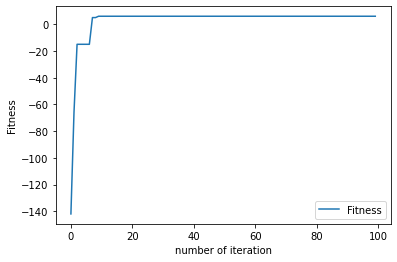

In [140]:
X=[i for i in range(100)]
Y=[]
for k in range(100):
    Y.append(fitness_results[k])
plt.plot(X,Y,label='Fitness')
plt.xlabel('number of iteration')
plt.ylabel('Fitness')
plt.legend()
plt.show()

